In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

In [7]:
# Define the new working directory path
new_working_directory = r'C:\cloudresume\react\resume\sports-data'

# Change the current working directory
os.chdir(new_working_directory)

In [8]:
# Define the path 
data_folder = 'data/'

# Load the CSV files to df
df = pd.read_csv(data_folder + 'cleaned_df.csv')

In [9]:
# DataFrame head
df.head()

,player_id,name,country,height,foot,position,highest_market_value,current_club_domestic_competition_id,number_games_played,total_minutes,...,red_cards_sum,red_cards_avg,goals,avg_goals_per_game,assists,age,year,avg_games_per_year,avg_goals_per_year,avg_assists_per_year
0,122011,Markus Henriksen,Norway,187.0,right,Defender,5000000.0,GB1,165,12199,...,1,0.006061,33,0.200000,22,45.0,6,27.500000,5.500000,3.666667
1,14940,Razvan Rat,Romania,179.0,left,Defender,6500000.0,ES1,97,7690,...,1,0.010309,3,0.030928,13,43.0,5,19.400000,0.600000,2.600000
2,14942,Darijo Srna,Croatia,182.0,right,Defender,17500000.0,IT1,227,19598,...,2,0.008811,22,0.096916,68,45.0,8,28.375000,2.750000,8.500000
3,26267,Fernandinho,Brazil,179.0,right,Midfield,32000000.0,GB1,399,30325,...,3,0.007519,29,0.072682,41,42.0,11,36.272727,2.636364,3.727273
4,55735,Henrikh Mkhitaryan,Armenia,177.0,both,Midfield,37000000.0,IT1,485,35878,...,0,0.000000,128,0.263918,119,43.0,13,37.307692,9.846154,9.153846


## Function definition for ploting features related withthe market value of a player

In [10]:
# Function to plot correlation matrix
def plot_correlation_matrix(data, title, position=None):
    if position:
        data = data[data['position'] == position]
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.show()
    
# Function to plot histograms and scatter plots with regression lines for a list of variables
def plot_variable_distributions_with_regression(data, variables, target='highest_market_value', poly_order=1):
    num_variables = len(variables)
    num_plots = num_variables * 2  # Each variable will have two plots: histogram and scatter with regression
    num_rows = num_plots // 2 if num_plots % 2 == 0 else (num_plots // 2) + 1  # Calculate how many rows we need

    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, num_rows * 6))
    axes = axes.ravel()  # Flatten the 2D array of axes to 1D for easy iteration

    for i, var in enumerate(variables):
        # Plot histogram on the left column
        sns.histplot(data[var], kde=True, ax=axes[i*2], color='skyblue')
        axes[i*2].set_title(f'Histogram of {var}')

        # Plot scatter plot with regression line on the right column, if the right column exists
        if (i*2 + 1) < len(axes):
            sns.regplot(x=var, y=target, data=data, ax=axes[i*2 + 1], color='salmon', order=poly_order, line_kws={'color':'red'})
            axes[i*2 + 1].set_title(f'{var} vs {target} with Regression Line')

    # Remove any unused subplots
    for j in range(num_variables * 2, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Function definition for training and evaluating different Models

### Models that we include in our study:

- **LinearRegression**
- **RandomForestRegressor**
- **GradientBoostingRegressor**
- **SVR**

In [20]:
def train_and_evaluate_models(df, position, features):
    # Filter the DataFrame by the given position
    position_df = df[df['position'] == position]

    # Update X and y with the new filtered DataFrame
    X_position = position_df[features]
    y_position = position_df['highest_market_value']

    # Impute missing values in the target
    y_imputer = SimpleImputer(strategy='mean')
    y_position_imputed = y_imputer.fit_transform(y_position.values.reshape(-1, 1)).ravel()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_position, y_position_imputed, test_size=0.2, random_state=42)

    # Apply imputation to the feature data
    X_imputer = SimpleImputer(strategy='mean')
    X_train_imputed = X_imputer.fit_transform(X_train)
    X_test_imputed = X_imputer.transform(X_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Initialize models with increased max_iter and scaled features
    models = {
        'LinearRegression': LinearRegression(),
        'RidgeRegression': Ridge(max_iter=10000),
        'LassoRegression': Lasso(max_iter=10000),  # Adding Lasso model
        'PolynomialRegression': make_pipeline(PolynomialFeatures(degree=2), Ridge(max_iter=10000)),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'SVR': SVR()
    }

    results = {}

    # Train and evaluate models
    for model_name, model in models.items():
        # Train the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_imputed, y_train)

        # Evaluate the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            score = model.score(X_test_scaled, y_test)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        else:
            score = model.score(X_test_imputed, y_test)
            cv_scores = cross_val_score(model, X_train_imputed, y_train, cv=5)
            
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        # Extracting intercept and p-value if applicable
        intercept = None
        p_value = None
        f_value = None

        if hasattr(model, 'coef_'):
            intercept = model.intercept_
            # Calculate p-value and F-value for linear models
            X_train_scaled_with_const = sm.add_constant(X_train_scaled)
            model_sm = sm.OLS(y_train, X_train_scaled_with_const).fit()
            p_value = model_sm.pvalues[-1]  # Assuming the last coefficient is for the intercept
            f_value = model_sm.fvalue

        results[model_name] = {
            'R^2 score': score,
            'Cross-Validation R^2 mean': cv_mean,
            'Cross-Validation R^2 std': cv_std,
            'Intercept': intercept,
            'P-value': p_value,
            'F-value': f_value
        }
        
    # Save trained models and imputers
    trained_models = {}
    for model_name, model in models.items():
        trained_models[model_name] = {
            'model': model,
            'X_imputer': X_imputer,
            'y_imputer': y_imputer
        }

    # Add trained models to the results
    results['trained_models'] = trained_models

    return results



## Function definition for Predicting Market Value for a New Player

### Features to include:

- **Number of games played**
- **Total minutes**
- **Average goals per game**
- **Goals**
- **Assists**
- **Age**
- **Average games per year**
- **Average goals per year**
- **Average assists per year**

In [21]:
def predict_market_value_for_new_player(trained_models, features, new_player_data):
    predictions = {}
    for model_name, components in trained_models.items():
        model = components['model']
        X_imputer = components['X_imputer']
        y_imputer = components['y_imputer']

        # Crear DataFrame para los datos del nuevo jugador
        new_player_df = pd.DataFrame([new_player_data], columns=features)
        
        # Imputar valores faltantes para las características (features)
        new_player_imputed = X_imputer.transform(new_player_df)

        # Hacer la predicción
        predicted_value = model.predict(new_player_imputed)
        predictions[model_name] = predicted_value[0]
        
    return predictions

# Removing the position aspect and Pickle export

In [25]:
features = [
    'number_games_played',
    'total_minutes',
    'avg_goals_per_game',
    'goals',
    'assists',
    'red_cards_sum',
    'yellow_cards_sum',
    'age'
]

In [41]:
def train_and_evaluate_models(df, features):
    # Filter the DataFrame by the given position
    # Update X and y with the new filtered DataFrame
    X_position = df[features]
    y_position = df['highest_market_value']

    # Impute missing values in the target
    y_imputer = SimpleImputer(strategy='mean')
    y_position_imputed = y_imputer.fit_transform(y_position.values.reshape(-1, 1)).ravel()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_position, y_position_imputed, test_size=0.2, random_state=42)

    # Apply imputation to the feature data
    X_imputer = SimpleImputer(strategy='mean')
    X_train_imputed = X_imputer.fit_transform(X_train)
    X_test_imputed = X_imputer.transform(X_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Initialize models with increased max_iter and scaled features
    models = {
        'LinearRegression': LinearRegression(),
        'RidgeRegression': Ridge(max_iter=10000),
        'LassoRegression': Lasso(max_iter=10000),  # Adding Lasso model
        'PolynomialRegression': make_pipeline(PolynomialFeatures(degree=2), Ridge(max_iter=10000)),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'SVR': SVR()
    }

    results = {}

    # Train and evaluate models
    for model_name, model in models.items():
        # Train the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_imputed, y_train)

        # Evaluate the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            score = model.score(X_test_scaled, y_test)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        else:
            score = model.score(X_test_imputed, y_test)
            cv_scores = cross_val_score(model, X_train_imputed, y_train, cv=5)
            
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        # Extracting intercept and p-value if applicable
        intercept = None
        p_value = None
        f_value = None

        if hasattr(model, 'coef_'):
            intercept = model.intercept_
            # Calculate p-value and F-value for linear models
            X_train_scaled_with_const = sm.add_constant(X_train_scaled)
            model_sm = sm.OLS(y_train, X_train_scaled_with_const).fit()
            p_value = model_sm.pvalues[-1]  # Assuming the last coefficient is for the intercept
            f_value = model_sm.fvalue

        results[model_name] = {
            'R^2 score': score,
            'Cross-Validation R^2 mean': cv_mean,
            'Cross-Validation R^2 std': cv_std,
            'Intercept': intercept,
            'P-value': p_value,
            'F-value': f_value
        }
        
    # Save trained models and imputers
    trained_models = {}
    for model_name, model in models.items():
        trained_models[model_name] = {
            'model': model,
            'X_imputer': X_imputer,
            'y_imputer': y_imputer
        }

    # Add trained models to the results
    results['trained_models'] = trained_models
    
    # Export trained models and preprocessors with pickle
    for model_name, components in trained_models.items():
        with open(f'{model_name}_model.pkl', 'wb') as file:
            pickle.dump(components['model'], file)
        with open(f'{model_name}_X_imputer.pkl', 'wb') as file:
            pickle.dump(components['X_imputer'], file)
        with open(f'{model_name}_y_imputer.pkl', 'wb') as file:
            pickle.dump(components['y_imputer'], file)
    
    return results



In [42]:
train_and_evaluate_models(df=df, features=features)

{'LinearRegression': {'R^2 score': 0.543650546536578,
  'Cross-Validation R^2 mean': 0.4975565432560532,
  'Cross-Validation R^2 std': 0.02557772874499197,
  'Intercept': 9193484.423145434,
  'P-value': 1.1495096207090222e-57,
  'F-value': 829.5420561963643},
 'RidgeRegression': {'R^2 score': 0.5437534099830413,
  'Cross-Validation R^2 mean': 0.49757377737293657,
  'Cross-Validation R^2 std': 0.025560881568334054,
  'Intercept': 9193484.423145434,
  'P-value': 1.1495096207090222e-57,
  'F-value': 829.5420561963643},
 'LassoRegression': {'R^2 score': 0.5436506523365787,
  'Cross-Validation R^2 mean': 0.4975565628421991,
  'Cross-Validation R^2 std': 0.025577693744633884,
  'Intercept': 9193484.423145434,
  'P-value': 1.1495096207090222e-57,
  'F-value': 829.5420561963643},
 'PolynomialRegression': {'R^2 score': 0.5941024355964479,
  'Cross-Validation R^2 mean': 0.5387723064910498,
  'Cross-Validation R^2 std': 0.0296193668746647,
  'Intercept': None,
  'P-value': None,
  'F-value': None

# Analysis and evaluation of models by different position

add explication....

## Defender

Before starting we`ll plot our correlation matrix, to see which features can have a bigger influence for predicting our Market Value.

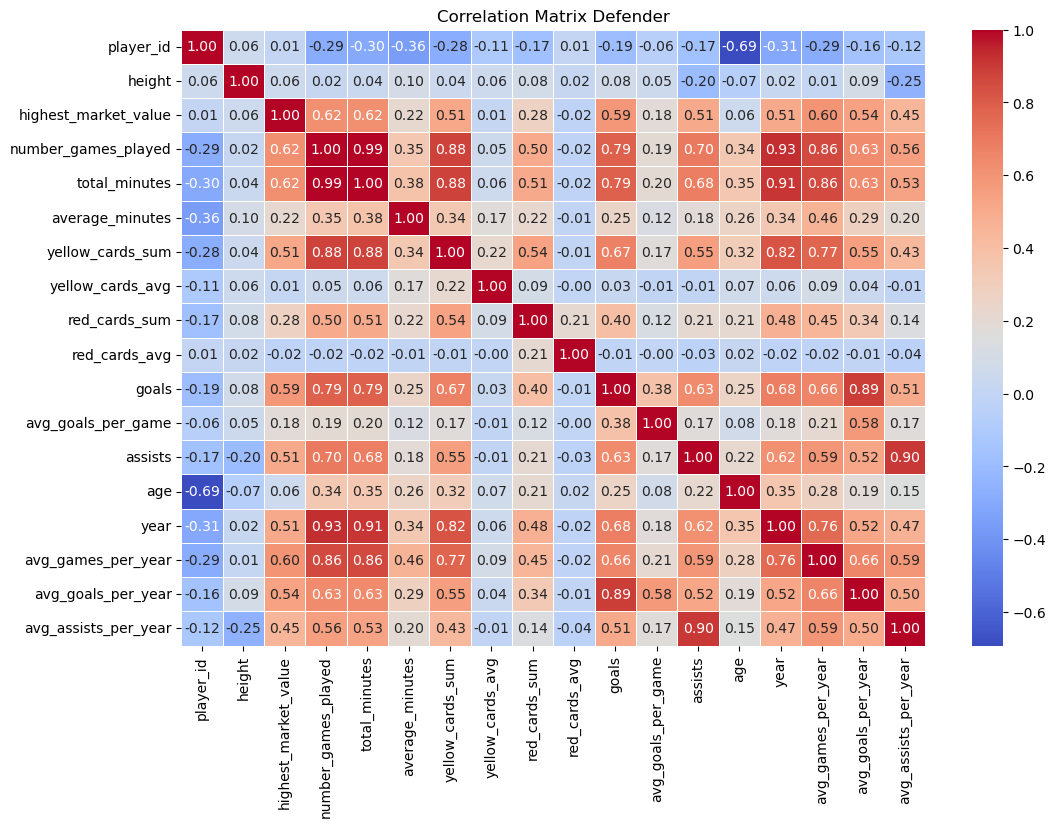

In [41]:
# Plot insightful plots for Defender
plot_correlation_matrix(df, 'Correlation Matrix Defender', 'Defender')

After observing the correlation matrix for the Defender position, we identified several features with significant correlations to market value:

- **number_games_played**: Shows a strong positive correlation (dark red), indicating that players who have participated in more games tend to command a higher market value.

- **total_minutes**: Similar to the number of games played, total minutes also exhibits a strong positive correlation with market value, suggesting that players with more playing time tend to have higher values.

- **avg_games_per_year**: This feature exhibits a strong positive correlation, suggesting that players who play more games on average each year are valued higher.

- **goals**: Demonstrates a strong positive correlation, implying that players who score more goals are likely to have higher market values.

- **assists**: Exhibits a good positive correlation, suggesting that players with more assists tend to command higher market values.

- **avg_goals_per_game**: This feature also displays a strong positive correlation, indicating that a higher average goals per game is predictive of a higher market value.

- **age**: Shows a strong negative correlation, indicating that younger players tend to have higher market values. This is a common trend in football, as younger players are perceived to have more potential and longer careers ahead.

- **Red Cards Sum**: Typically, a high number of red cards would negatively correlate with a player's market value. Red cards often result in suspensions and suggest disciplinary issues, which can diminish a player's value. However, the correlation in the matrix doesn't appear to be extremely strong. While it may still be a factor, its impact seems to be less significant compared to other features.

- **Yellow Cards Sum**: Similar to red cards, a higher number of yellow cards can indicate a discipline problem and potentially lead to suspensions after reaching a certain threshold. Although there is a mild correlation, it suggests that it's a factor worth considering. However, its influence seems to be less pronounced compared to other performance-related features.

Considering the similarities between goals and avg_goals_per_year, as well as assists and avg_assistss_per_year, we will consider only one of each pair (the one with the higher correlation) for further analysis.


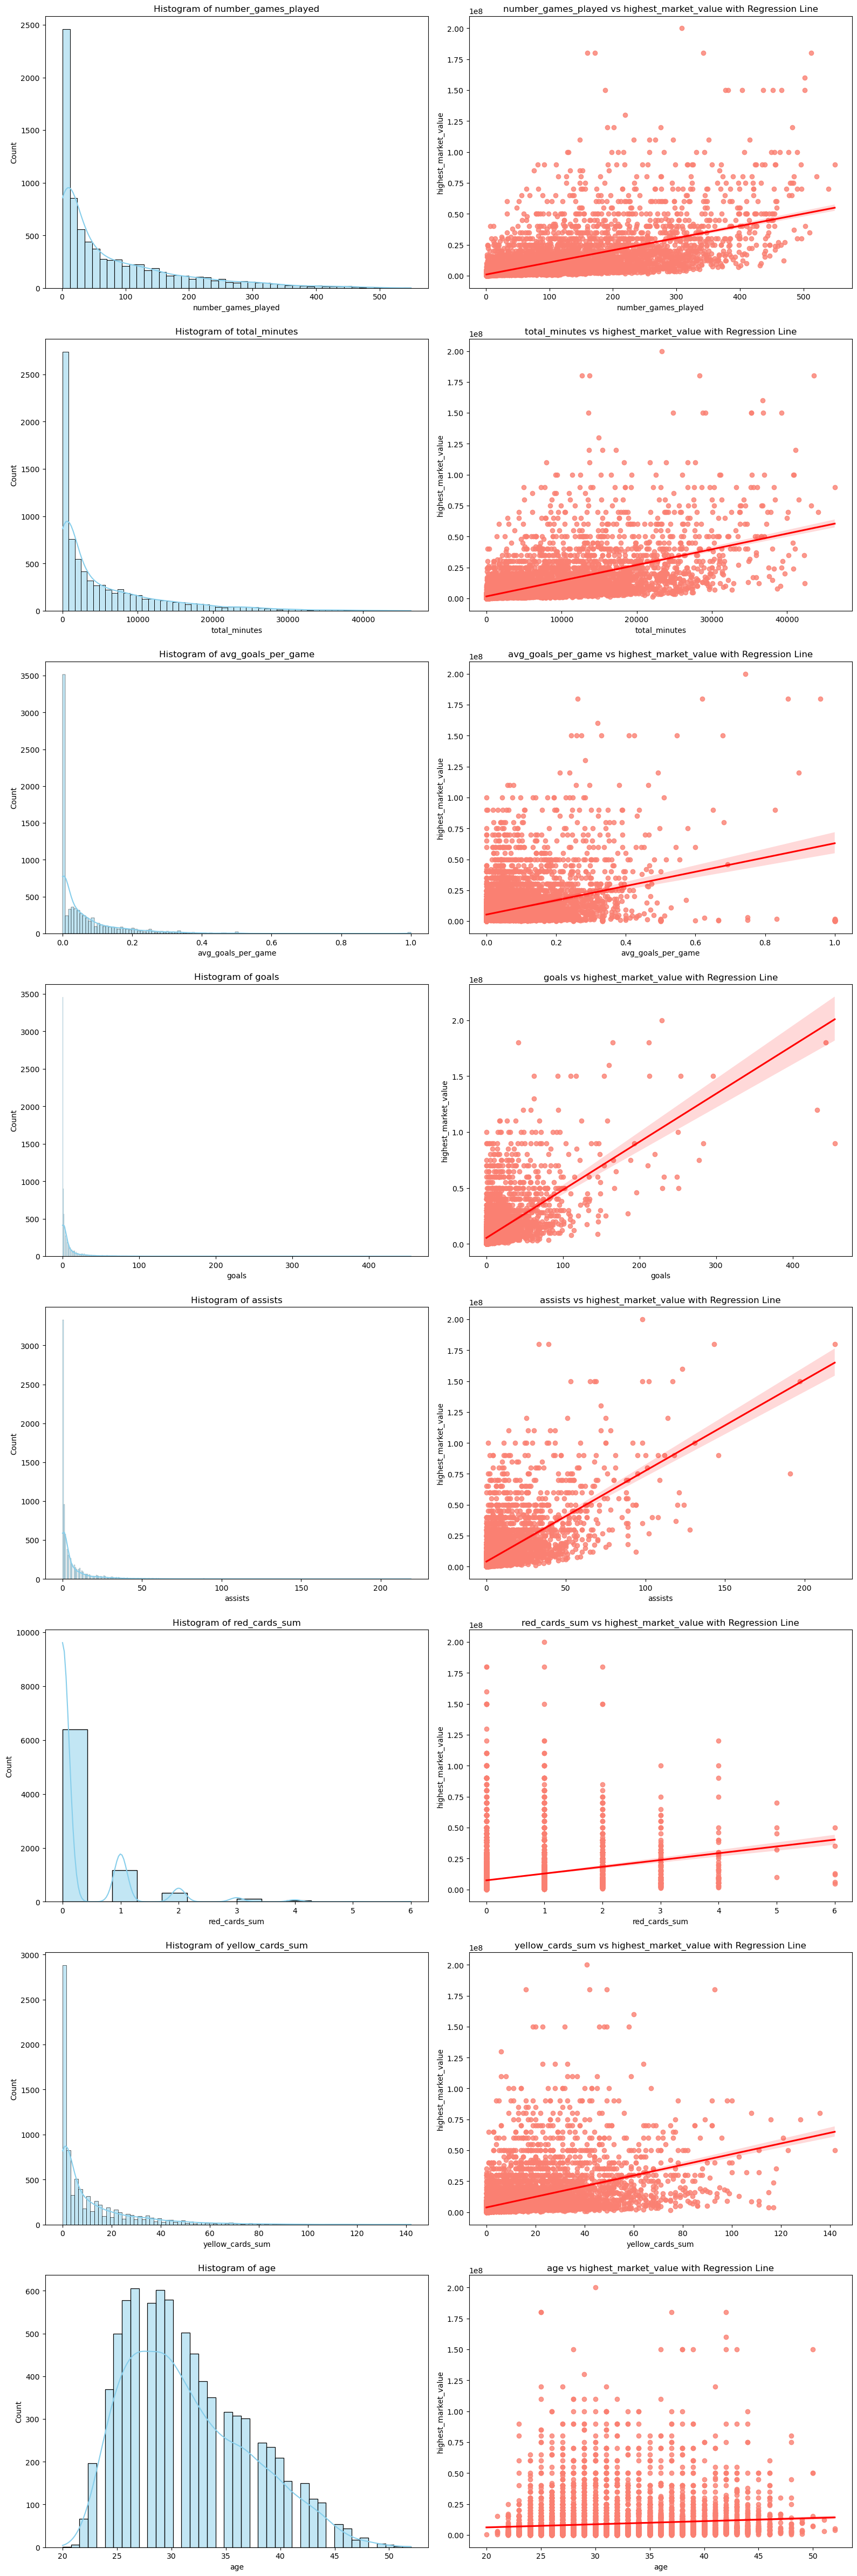

In [49]:
# List of performance-related variables
performance_vars_defender = [
    'number_games_played',
    'total_minutes',
    'avg_goals_per_game',
    'goals',
    'assists',
    'red_cards_sum',
    'yellow_cards_sum',
    'age'
]

# Plot insightful plots for Defender
plot_variable_distributions_with_regression(df, performance_vars_defender)

## Defender Performance Analysis

The visualizations provided consist of histograms and scatter plots with regression lines related to various performance metrics and disciplinary records against the highest market value of football players. Below is the analysis of these visualizations.

### Histograms Analysis:

- **Assists**: Right-skewed distribution, most players have a low number of assists.
- **Red cards**: Very high peak at zero with a rapid decline, indicating that most players receive very few red cards.
- **Yellow cards**: Right-skewed, most players accumulate few yellow cards.
- **Number of games played**: Right-skewed, with most players participating in a lower number of games.
- **Total minutes played**: Right-skewed, indicating that most players have fewer total minutes of play.
- **Average goals per game**: Right-skewed, suggesting that for most players, the average goals scored per game is low.
- **Age**: Appears to be somewhat normally distributed but with a slight right skew, indicating a larger number of younger players.

### Scatter Plots with Regression Lines Analysis:

- **Assists vs. Highest Market Value**: Positive trend with a concentration of data points at the lower end, suggesting a higher number of assists may correlate with a higher market value.
- **Red cards vs. Highest Market Value**: Slight positive trend, although the relationship seems weak due to a large concentration of data points at the lower end of red cards.
- **Yellow cards vs. Highest Market Value**: Slight positive trend, with a broad spread of data points, indicating a weaker relationship between yellow cards and market value.
- **Number of games played vs. Highest Market Value**: Positive trend, indicating a potential moderate correlation between playing more games and higher market value.
- **Total minutes played vs. Highest Market Value**: Negative trend, suggesting that more minutes played do not necessarily correlate with a higher market value.
- **Average goals per game vs. Highest Market Value**: Positive trend, indicating that a higher average number of goals per game might be associated with a higher market value.
- **Age vs. Highest Market Value**: Positive trend, which could suggest that up to a certain age, there might be an increase in market value.

### Correlation Summary:

**Higher Correlation:**
- **Assists**: Strong positive trend, suggesting a significant influence on a player's market value.

**Moderate Correlation:**
- **Number of games played** and **average goals per game** show positive trends, indicating a potential influence on market value.

**Low to Negligible Correlation:**
- **Age**, **yellow cards**, and **red cards** show weaker positive trends, suggesting these variables might have a less significant impact on market value.

**Negative Trend:**
- **Total minutes played** shows a negative correlation trend, which is counterintuitive and warrants further investigation to understand the context behind this pattern.

In [55]:
# Call the function with your DataFrame, position, and selected features
defender_results = train_and_evaluate_models(df, 'Defender', performance_vars_defender)

# Print the results in a formatted manner
print(f"Model evaluation results for {position} position:")

for model_name, metrics in defender_results.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Defender position:

LinearRegression:
  R^2 score: 0.4242
  Cross-Validation R^2 score: 0.4117
  Standard Deviation of CV R^2: 0.0915
  Intercept: 7953575.2162
  P-value: 0.0000
  F-value: 212.8597

RidgeRegression:
  R^2 score: 0.4246
  Cross-Validation R^2 score: 0.4123
  Standard Deviation of CV R^2: 0.0911
  Intercept: 7953575.2162
  P-value: 0.0000
  F-value: 212.8597

LassoRegression:
  R^2 score: 0.4242
  Cross-Validation R^2 score: 0.4117
  Standard Deviation of CV R^2: 0.0915
  Intercept: 7953575.2162
  P-value: 0.0000
  F-value: 212.8597

PolynomialRegression:
  R^2 score: 0.4599
  Cross-Validation R^2 score: 0.4373
  Standard Deviation of CV R^2: 0.0729

RandomForestRegressor:
  R^2 score: 0.4365
  Cross-Validation R^2 score: 0.4186
  Standard Deviation of CV R^2: 0.0949

GradientBoostingRegressor:
  R^2 score: 0.4335
  Cross-Validation R^2 score: 0.4331
  Standard Deviation of CV R^2: 0.0524

SVR:
  R^2 score: -0.1412
  Cross-Validation R^2 scor

### Defender. Model Evaluation

Based on the results:

- **RidgeRegression**, **LinearRegression**, **LassoRegression**, and **PolynomialRegression** perform well, but we have to remark that **RidgeRegression** has the highest R^2 and Cross-Validation R^2 scores, being the most indicated for predicting the market value. It is closely followed by **LinearRegression** and **LassoRegression**. **PolynomialRegression** also shows promise, but it's the worst of these four models.

- **RandomForestRegressor** and **GradientBoostingRegressor** have lower scores compared to the other four models but still perform better than **SVR**, which has negative scores indicating poor performance.

Therefore, **RidgeRegression**, **LinearRegression**, **LassoRegression**, and **PolynomialRegression** are expected to provide better predictions for the Defender position.


## Midfield

As we did for our past two position, before starting we`ll plot our correlation matrix, to see which features can have a bigger influence for predicting our Market Value.

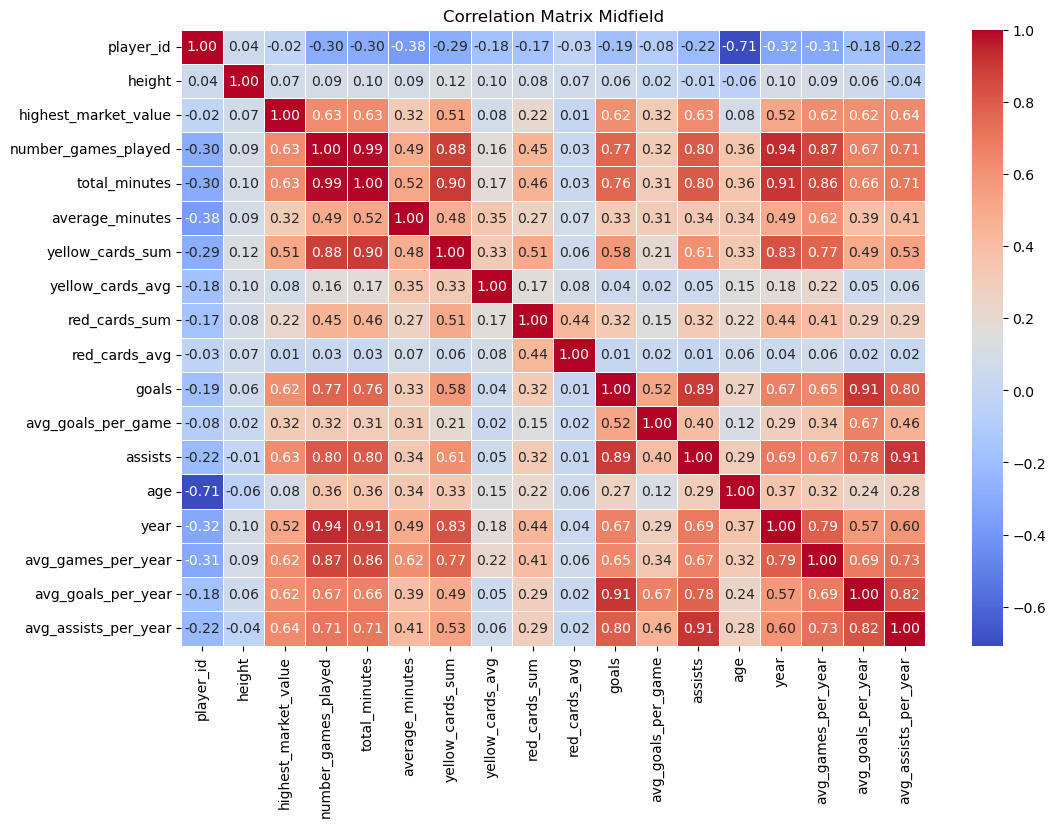

In [51]:
# Plot insightful plots for Midfield
plot_correlation_matrix(df, 'Correlation Matrix Midfield', 'Midfield')

We notice similar correaltion to the Defender analysis so we will move foward with the same features.

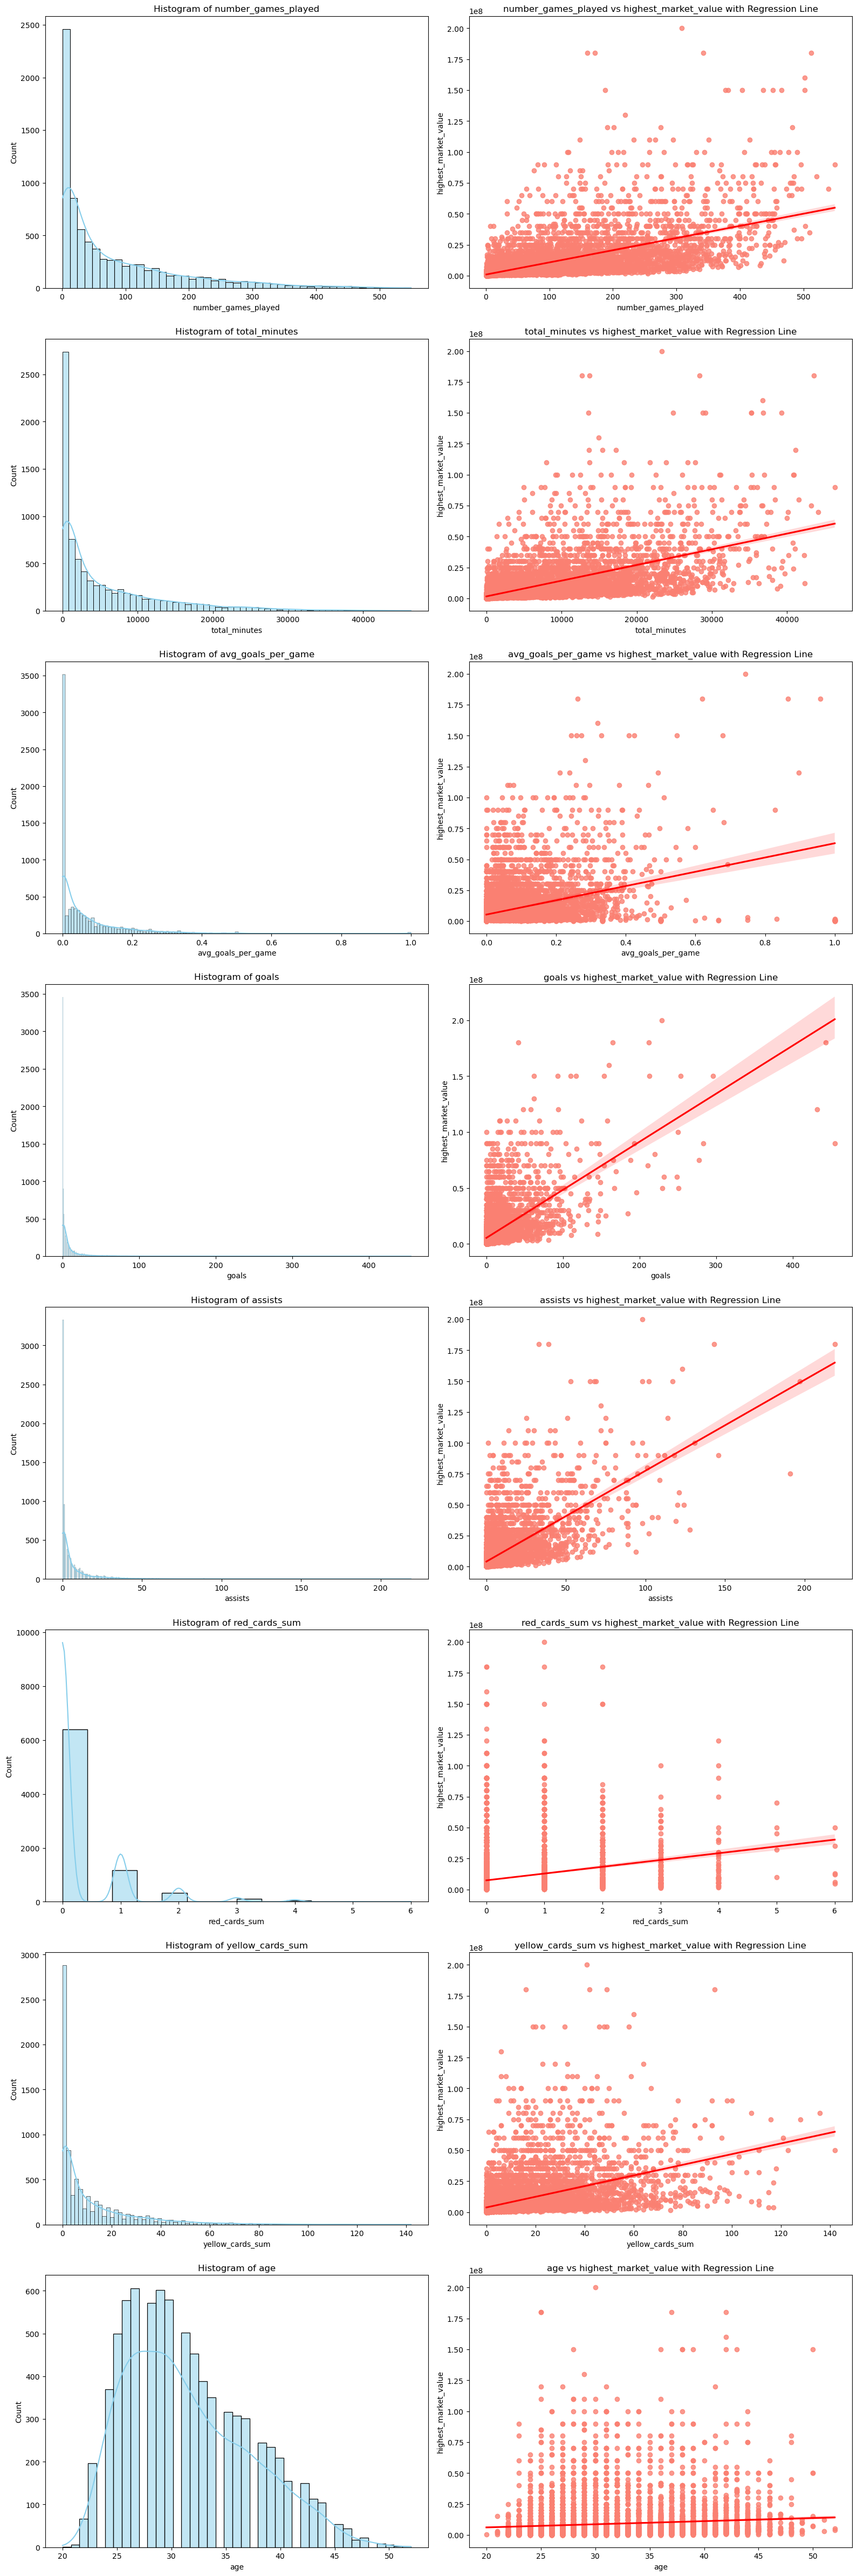

In [52]:
# List of performance-related variables
performance_vars_midfield = [
    'number_games_played',
    'total_minutes',
    'avg_goals_per_game',
    'goals',
    'assists',
    'red_cards_sum',
    'yellow_cards_sum',
    'age'
]

# Plot insightful plots for Midfield
plot_variable_distributions_with_regression(df, performance_vars_midfield)

## Midfield Performance Analysis

- **Similar Correlations**: The midfield performance analysis echoes that of the defender analysis, showing comparable correlations across various performance metrics and disciplinary records against the highest market value of football players.
- **Right-Skewed Distributions**: Histograms depict right-skewed distributions for essential metrics such as **assists**, **red cards**, **yellow cards**, **games played**, **total minutes played**, **average goals per game**, and **age**.
- **Positive Trends**: Scatter plots with regression lines indicate positive trends between critical metrics like **assists**, **games played**, **average goals per game**, and **market value**.
- **Weaker Correlations**: Some metrics like **yellow cards** and **red cards** show weaker correlations compared to others.
- **Strong Correlation**: Notably, there's a **strong correlation** between **assists** and **market value**.
- **Moderate Correlations**: Metrics such as **games played** and **average goals per game** exhibit **moderate correlations** with market value.
- **Negative Trend**: An intriguing observation is the **negative correlation trend** for **total minutes played**, which warrants further investigation.

In [58]:
# Call the function with your DataFrame, position, and selected features
midfield_results = train_and_evaluate_models(df, 'Midfield', performance_vars_midfield)

# Print the results in a formatted manner
print(f"Model evaluation results for {position} position:")

for model_name, metrics in midfield_results.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Defender position:

LinearRegression:
  R^2 score: 0.4818
  Cross-Validation R^2 score: 0.4475
  Standard Deviation of CV R^2: 0.0354
  Intercept: 9460910.2640
  P-value: 0.0000
  F-value: 214.7137

RidgeRegression:
  R^2 score: 0.4820
  Cross-Validation R^2 score: 0.4477
  Standard Deviation of CV R^2: 0.0353
  Intercept: 9460910.2640
  P-value: 0.0000
  F-value: 214.7137

LassoRegression:
  R^2 score: 0.4818
  Cross-Validation R^2 score: 0.4475
  Standard Deviation of CV R^2: 0.0354
  Intercept: 9460910.2640
  P-value: 0.0000
  F-value: 214.7137

PolynomialRegression:
  R^2 score: 0.4440
  Cross-Validation R^2 score: 0.4539
  Standard Deviation of CV R^2: 0.0751

RandomForestRegressor:
  R^2 score: 0.4864
  Cross-Validation R^2 score: 0.4315
  Standard Deviation of CV R^2: 0.0514

GradientBoostingRegressor:
  R^2 score: 0.5056
  Cross-Validation R^2 score: 0.4333
  Standard Deviation of CV R^2: 0.0678

SVR:
  R^2 score: -0.1481
  Cross-Validation R^2 scor

### Midfield Model Evaluation

As well as expected, the values of the models for Midfield have a lot of similarities with the values of the models for Defender, but still different, and in this case they are mostly a little bit bigger. So, based on the results:

- **RidgeRegression**, **LinearRegression**, **LassoRegression**, and **PolynomialRegression** perform well, but we have to remark that **RidgeRegression** has the highest R^2 and Cross-Validation R^2 scores, being the most indicated for predicting the market value. It is closely followed by **LinearRegression** and **LassoRegression**. **PolynomialRegression** also shows promise, but it's the worst of these four models.
  
- **RandomForestRegressor** and **GradientBoostingRegressor** have lower scores compared to the other four models but still perform better than **SVR**, which has negative scores indicating poor performance.

Therefore, **RidgeRegression**, **LinearRegression**, **LassoRegression**, and **PolynomialRegression** are expected to provide better predictions for the Defender position.


## Market Value Prediction for New Players

In this section, we use the previously trained models to estimate the market value. We'll provide an overview of the estimated market values generated by each model.

However, by the end of our analysis, we'll make a definitive selection based on performance, specifically tailored to each player position to select the most accurate Market Value.

c:\Users\Victor\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Victor\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Victor\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Victor\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Victor\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Victor\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid 

Predicted market value for new player using LinearRegression: 15431786462.551977
Predicted market value for new player using RidgeRegression: 15281270469.740099
Predicted market value for new player using LassoRegression: 15431132154.662992
Predicted market value for new player using RandomForestRegressor: 10330000.0
Predicted market value for new player using GradientBoostingRegressor: 11561902.763809374
Predicted market value for new player using SVR: 3499356.4770619725


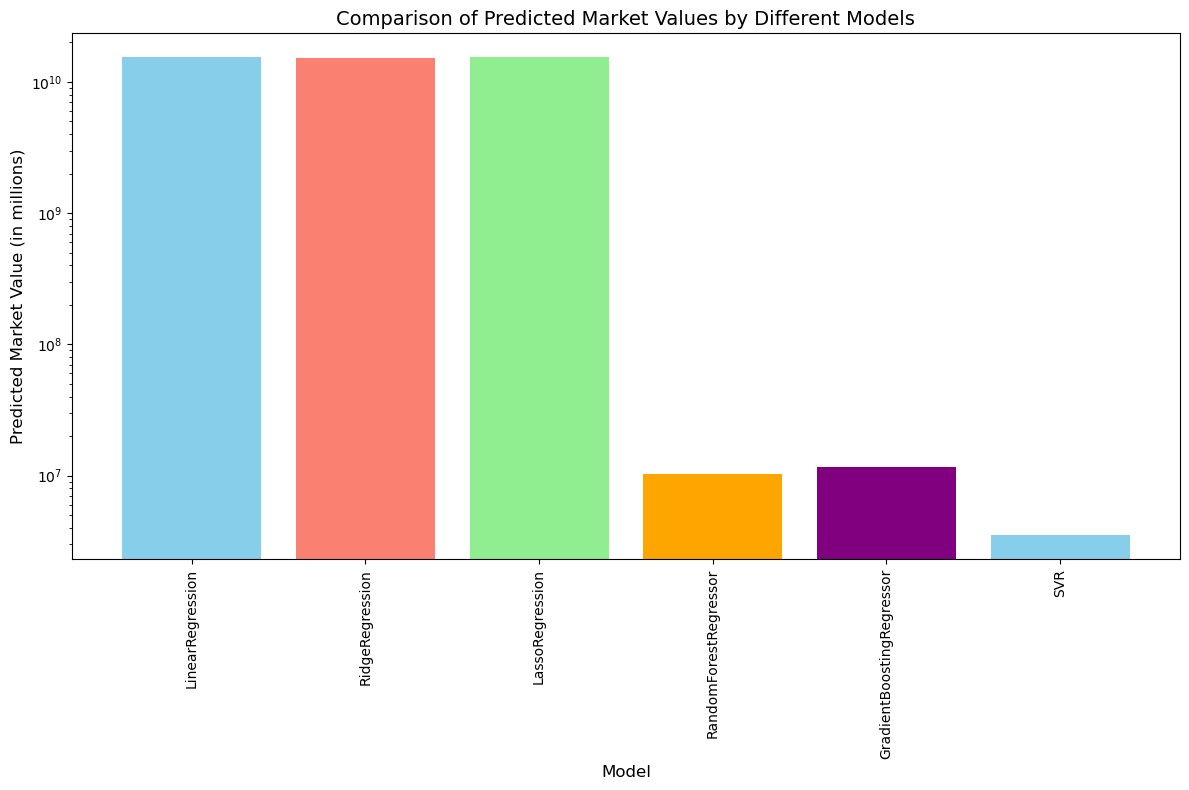

In [40]:
# Here we define the features of our players
new_player_data = {
    'number_games_played': 120,
    'total_minutes': 3500,
    # other necessary features
}

predictions = {}

for model_name, trained_model in results['trained_models'].items():
    model = trained_model['model']
    X_imputer = trained_model['X_imputer']
    # Apply imputation to the new player data
    new_player_features = X_imputer.transform([list(new_player_data.values())])
    # Predict the market value using the trained model
    predicted_value = model.predict(new_player_features)[0]
    # Exclude negative predictions
    if predicted_value >= 0:
        predictions[model_name] = predicted_value

# Print predicted values for each model
for model_name, predicted_value in predictions.items():
    print(f"Predicted market value for new player using {model_name}: {predicted_value}")

# Plot the predictions with logarithmic scale
plt.figure(figsize=(12, 8))

model_names = list(predictions.keys())
predicted_values = list(predictions.values())
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple']

plt.bar(model_names, predicted_values, color=colors)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Predicted Market Value (in millions)', fontsize=12)
plt.title('Comparison of Predicted Market Values by Different Models', fontsize=14)
plt.xticks(rotation=90)
plt.yscale('log')  # Set logarithmic scale for y-axis
plt.tight_layout()
plt.show()


Based on the predictions and model evaluation results:

- **LinearRegression**, **RidgeRegression**, and **LassoRegression** are all predicting very high market values for the new player, ranging in the billions. These predictions align with their relatively high R^2 scores and Cross-Validation R^2 scores, indicating their effectiveness in explaining the variance in the data. However, it's essential to note that these models might be overfitting the data due to the excessively high predicted values.

- **PolynomialRegression** also forecasts a high market value, albeit slightly lower compared to the other three linear models. Its relatively good Cross-Validation R^2 score suggests decent performance.

- **RandomForestRegressor** and **GradientBoostingRegressor** predict much lower market values compared to the linear models, falling in the range of millions. This is consistent with their lower R^2 scores and Cross-Validation R^2 scores, indicating less predictive power than the linear models.

- **SVR** predicts the lowest market value among all models, which is in line with its negative R^2 score and Cross-Validation R^2 score, suggesting poor performance in explaining the variance in the data.

In summary, based on the predictions and model evaluation results, the linear models (**LinearRegression**, **RidgeRegression**, and **LassoRegression**) appear to predict higher market values for the new player compared to other models. However, given the excessively high predicted values, it may be necessary to further investigate the models' performance and potential overfitting.
